In [243]:
import sys

In [244]:
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install gym==0.25.1
!{sys.executable} -m pip install gym[toy_text]==0.25.1

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [245]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets


from mpl_toolkits.axes_grid1 import ImageGrid
import time
import math
import random

from timeit import default_timer as timer
%matplotlib inline

In [246]:
def movingAverage(data, window):
  cumsum = np.cumsum(np.insert(data,0,np.zeros(window)))
  ma = (cumsum[window:] - cumsum[:-window]) / window
  return ma

In [247]:
def calcPolicy(q_table):
  policy = np.empty((4,4))
  index = 0
  for row in q_table:
    if np.sum(row) == 0:
      policy[int(index/4),int(index%4) ] = float('nan')
    else:
      policy[int(index/4),int(index%4) ] = np.argmax(row)
    index += 1
  return policy

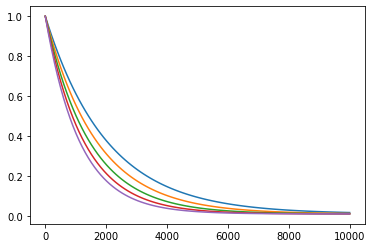

In [248]:
def explorationDecayRate(episodes,max,min,factor):
  decay_rate = (max-min)/episodes
  x = np.linspace(0,episodes,num=100)
  y = min+(max-min)*np.exp(-decay_rate*factor*x)
  plt.plot(x,y)

for i in range(5,10):
  explorationDecayRate(10000,1,0.01,i)

In [249]:
def runEpisode(env, q_table, learning_rate, discount, epsilon,  max_steps=200):
    state = env.reset()
    episode_score = 0
    for step in range(max_steps):

        # Decide an action

        if random.uniform(0, 1) > epsilon:
            action = np.argmax(q_table[state])
        else:
            action = env.action_space.sample()

        new_state, reward, terminated, _, _ = env.step(action)

        episode_score += reward

        current_q = q_table[state, action]
        max_future_q = np.max(q_table[new_state])

        q_table[state, action] = (
            1 - learning_rate) * current_q + learning_rate * (reward + discount * max_future_q)

        state = new_state

        if terminated:
            break

    return q_table, episode_score


In [250]:

def trainModel(env, episodes, learning_rate, discount, epsilon_decay, epsilon_max=1, epsilon_min=0.05, epsilon_delay=100):
    q_table = np.zeros([obs_space.n, act_space.n])
    rewards = []
    epsilon_values = []
    epsilon = epsilon_max
    previous_episode_score = -float('inf')

    for episode in range(episodes):

        q_table, episode_score = runEpisode(
            env, q_table, learning_rate, discount, epsilon)

        rewards.append(episode_score)
        epsilon_values.append(epsilon)
        if epsilon > epsilon_min and episode > epsilon_delay and episode_score > previous_episode_score:
            epsilon = epsilon_min + \
                (epsilon_max - epsilon_min) * \
                np.exp(-epsilon_decay * episode)

    return q_table, rewards, epsilon_values


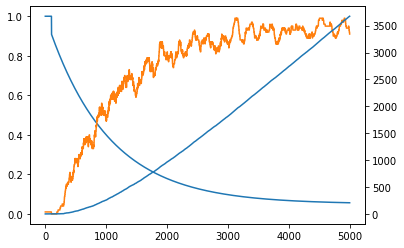

In [251]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False, new_step_api=True)

q_table, rewards, epsilon_values = trainModel(env,5000, learning_rate=0.4, discount=0.9, epsilon_decay=0.001)

fig, ax = plt.subplots()
twin = ax.twinx()
cumsum_rewards = np.cumsum(rewards)

ax.plot(epsilon_values)
twin.plot(cumsum_rewards)
ax.plot(movingAverage(rewards,100))


plt.show()


In [252]:
env = gym.make("FrozenLake-v1", map_name="4x4",
               is_slippery=False, new_step_api=True)

number_tests = 50
training_event_per_test = 50
number_episodes = 4000


max_learning_rate = 1
min_learning_rate = 0

max_discount = 1
min_discount = 0


learning_rate_space = np.linspace(
    min_learning_rate,max_learning_rate, number_tests)

learning_rate_average_rewards = []
learning_rate_average_smoothed_rewards = []


test_progress = widgets.FloatProgress(
    value=0,
    min=min_learning_rate,
    max=max_learning_rate,
    description='learning_rate:',
    bar_style='info',
    style={'bar_color': 'red'},
    orientation='horizontal'
)
event_progress = widgets.FloatProgress(
    value=0,
    min=0,
    max=training_event_per_test,
    description='training event:',
    bar_style='info',
    style={'bar_color': 'red'},
    orientation='horizontal'
)
display(test_progress)
display(event_progress)


for learning_rate in learning_rate_space:

    test_rewards = []
    test_smoothed_rewards = []

    for event in range(training_event_per_test):
        _, reward, _ = trainModel(
            env, number_episodes, learning_rate, 0.5, epsilon_decay=0.001)
        smoothed_reward = movingAverage(reward, 100)

        test_rewards.append(reward)
        test_smoothed_rewards.append(smoothed_reward)

        event_progress.value = event
        # plt.plot(smoothed_reward, label=event)

    test_reward_average = np.mean(test_rewards,0)
    test_reward_smoothed_average = movingAverage(test_reward_average, 100)
    
    # plt.plot(test_reward_smoothed_average, label="average")
    # plt.legend(title="Training Event", bbox_to_anchor=(1,1))
    # plt.title("Learning Rate: {0}".format(learning_rate))
    
    # plt.show()
    
    learning_rate_average_rewards.append(test_reward_average)
    learning_rate_average_smoothed_rewards.append(test_reward_smoothed_average)
    
    test_progress.value = learning_rate

# plt.show()


FloatProgress(value=0.0, bar_style='info', description='learning_rate:', max=1.0, style=ProgressStyle(bar_colo…

FloatProgress(value=0.0, bar_style='info', description='training event:', max=50.0, style=ProgressStyle(bar_co…

In [253]:
 
range_start_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=number_episodes,
    step=100,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
range_end_slider = widgets.IntSlider(
    value=number_episodes,
    min=0,
    max=number_episodes,
    step=100,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def figureRange(x,y):
  for test in range(len(learning_rate_space)):
    plt.plot(np.arange(x,y),np.asarray(learning_rate_average_smoothed_rewards)[test][x:y], label=learning_rate_space[test])
  plt.legend(title="Training Event", bbox_to_anchor=(1,1))
  plt.show()
  
  range_end_slider.min = x
  range_start_slider.max = y

widgets.interact(figureRange, x=range_start_slider, y = range_end_slider)


interactive(children=(IntSlider(value=0, description='Test:', max=4000, step=100), IntSlider(value=4000, descr…

<function __main__.figureRange(x, y)>

In [254]:
slice_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=number_episodes,
    step=50,
    description='Episode:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def plotSlice(x):
    plt.plot(learning_rate_space[1:], np.asarray(learning_rate_average_smoothed_rewards)[1:, x])
    plt.xlabel("Learning Rate")
    plt.ylabel("Score at episode")
    plt.show()

widgets.interact(plotSlice, x=slice_slider)
   


interactive(children=(IntSlider(value=0, description='Episode:', max=4000, step=50), Output()), _dom_classes=(…

<function __main__.plotSlice(x)>

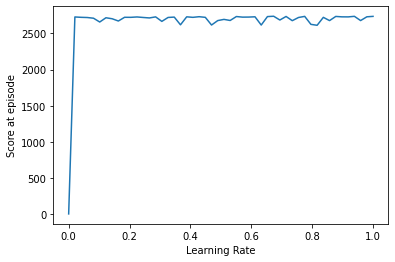

In [255]:
plt.plot(learning_rate_space[:], np.sum(learning_rate_average_rewards,1))
plt.xlabel("Learning Rate")
plt.ylabel("Score at episode")
plt.show()

FloatProgress(value=0.0, bar_style='info', description='discount:', max=1.0, style=ProgressStyle(bar_color='re…

FloatProgress(value=0.0, bar_style='info', description='training event:', max=50.0, style=ProgressStyle(bar_co…

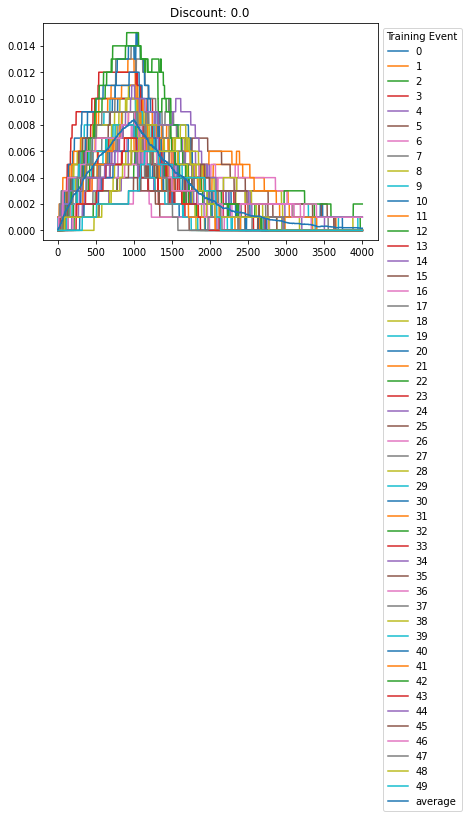

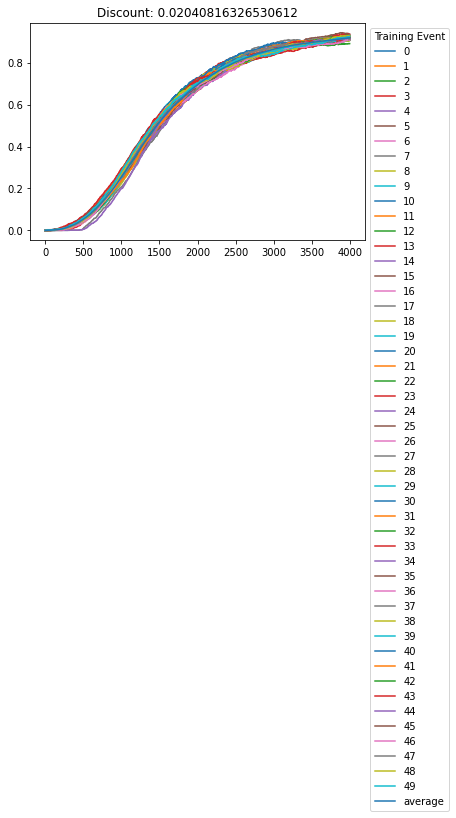

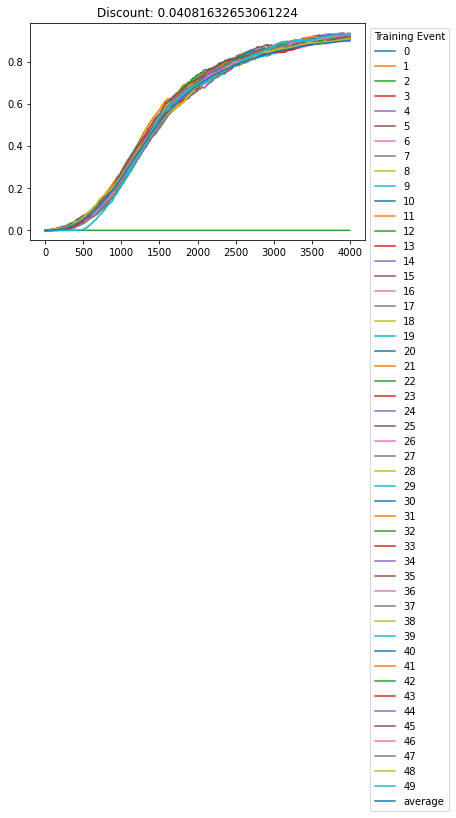

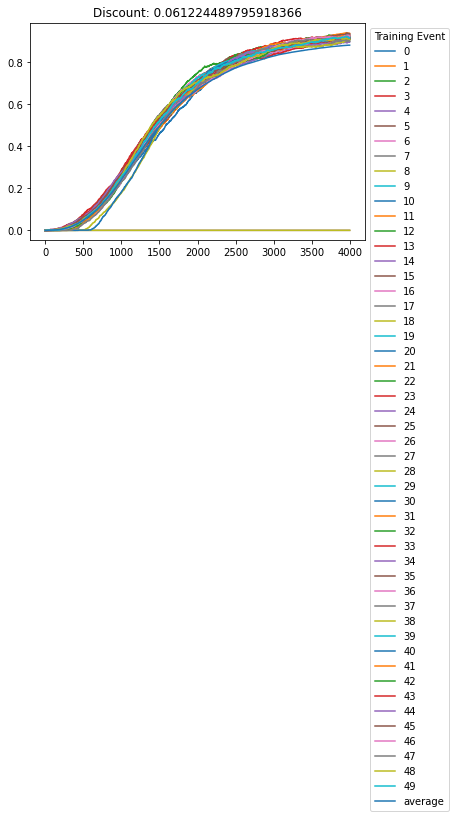

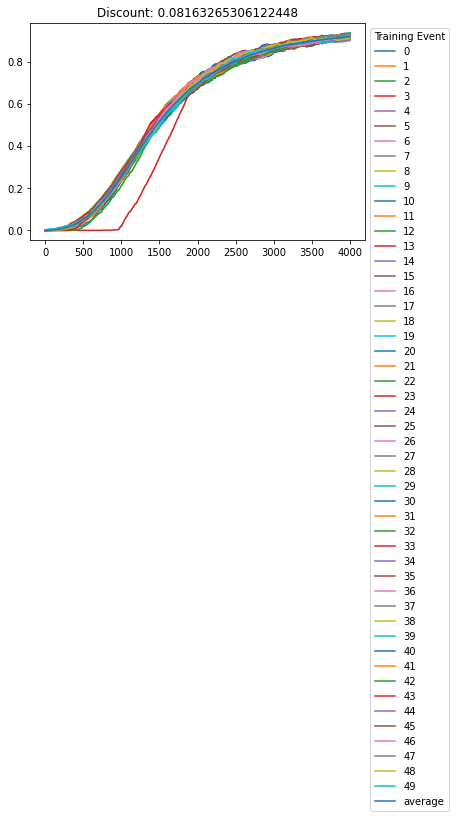

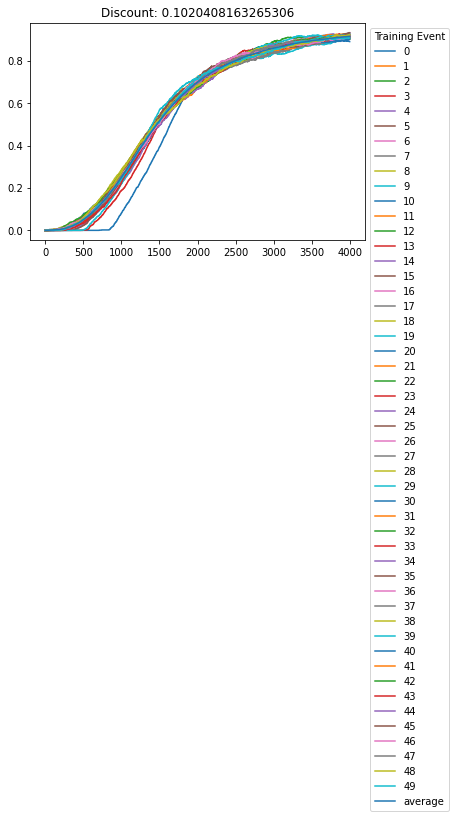

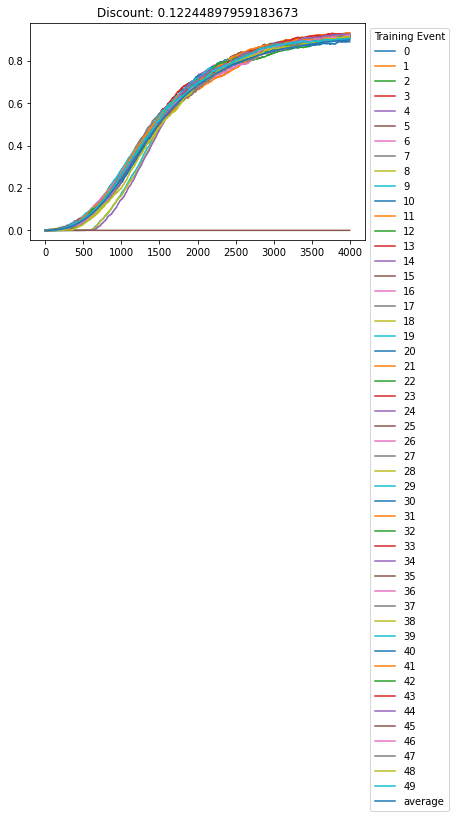

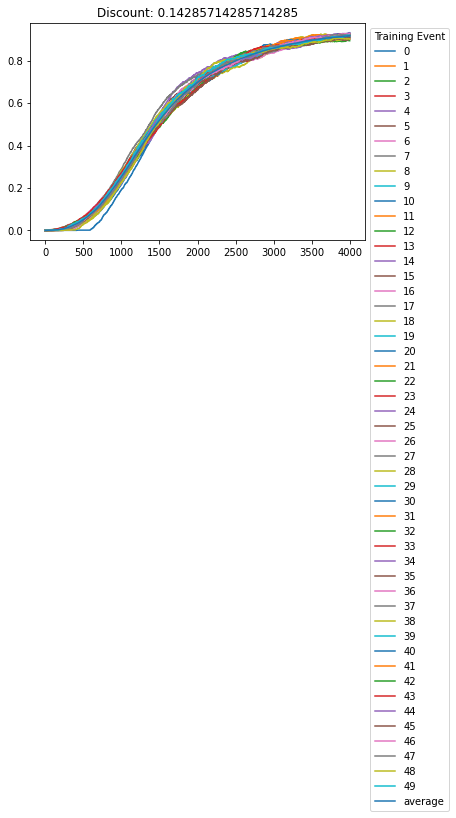

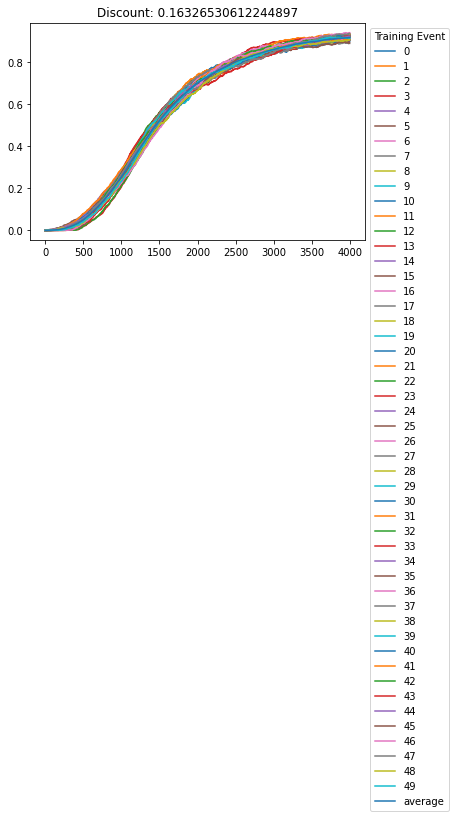

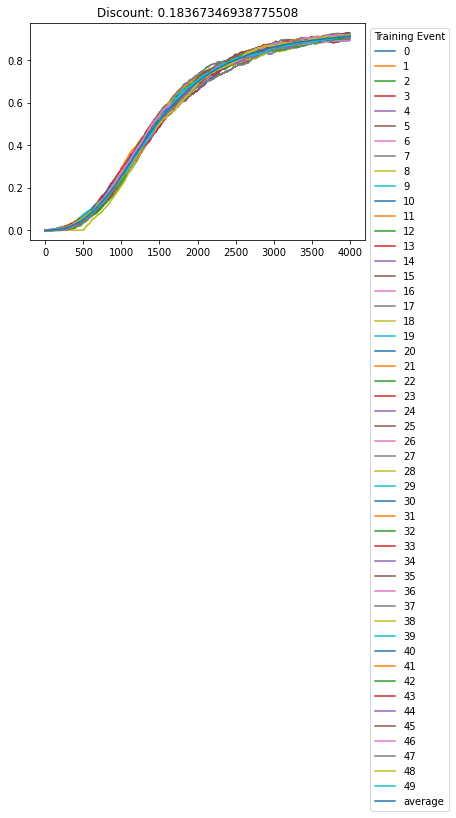

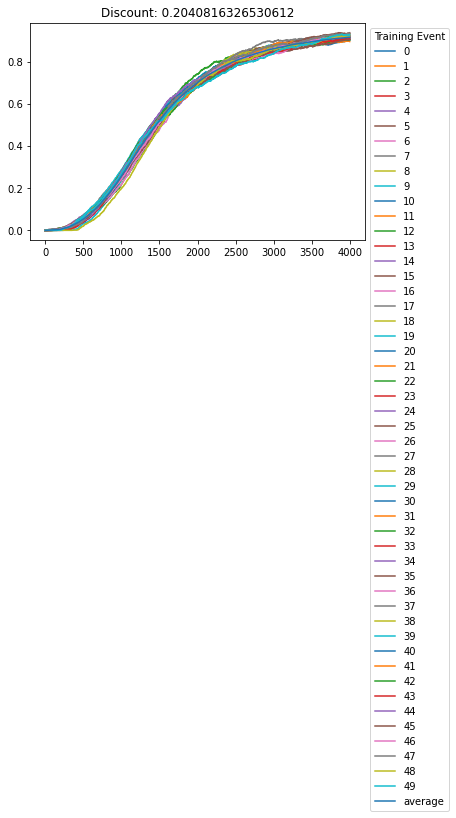

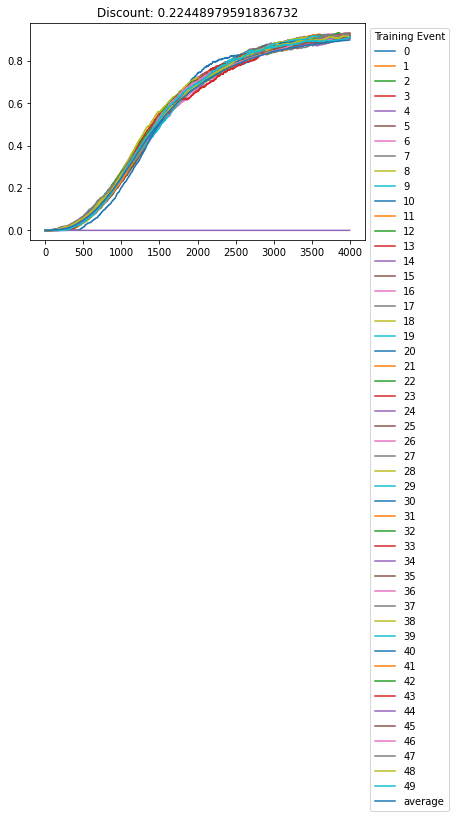

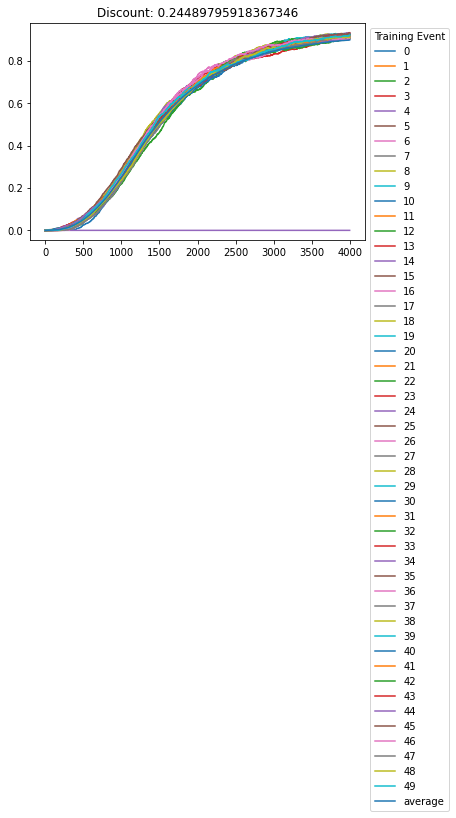

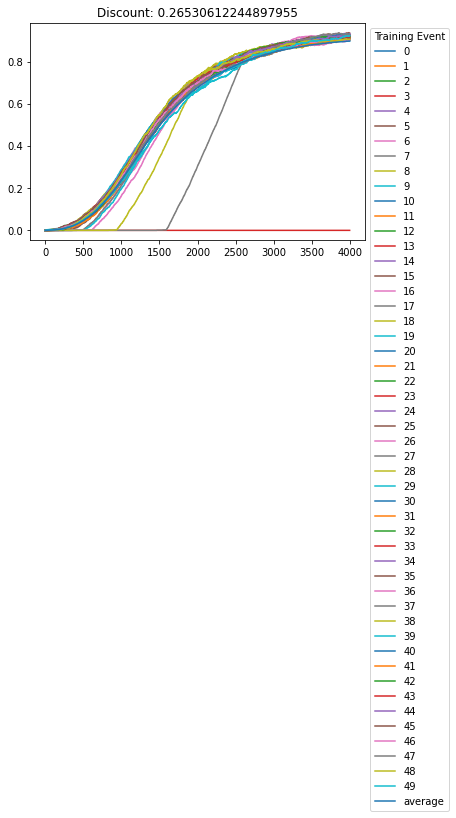

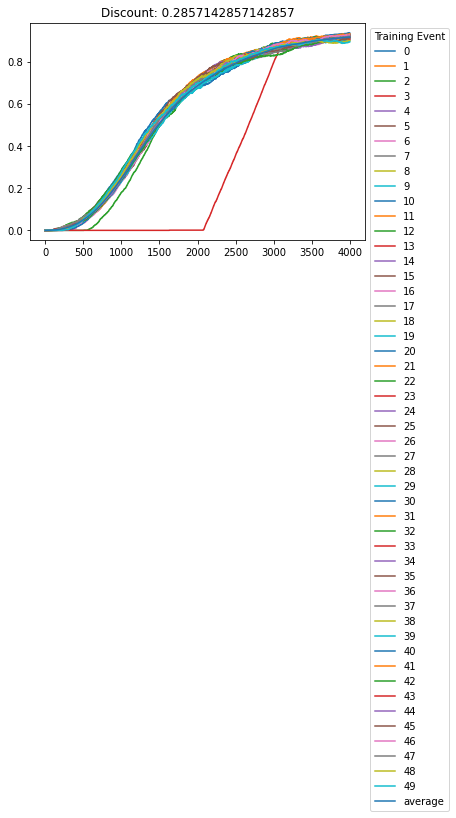

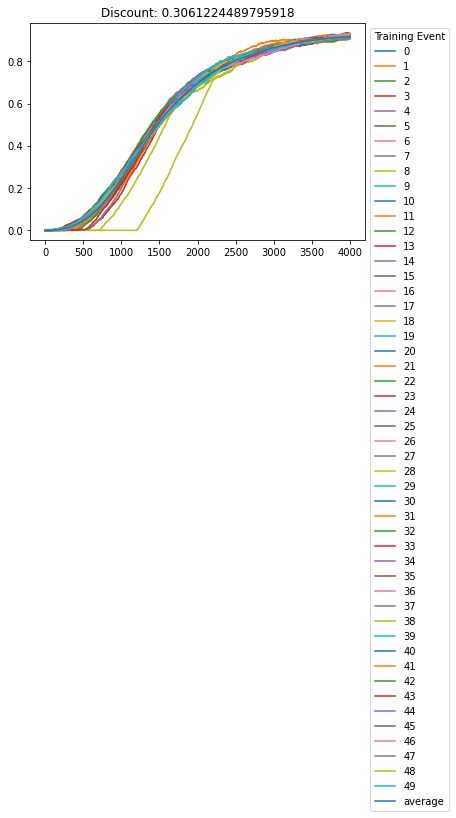

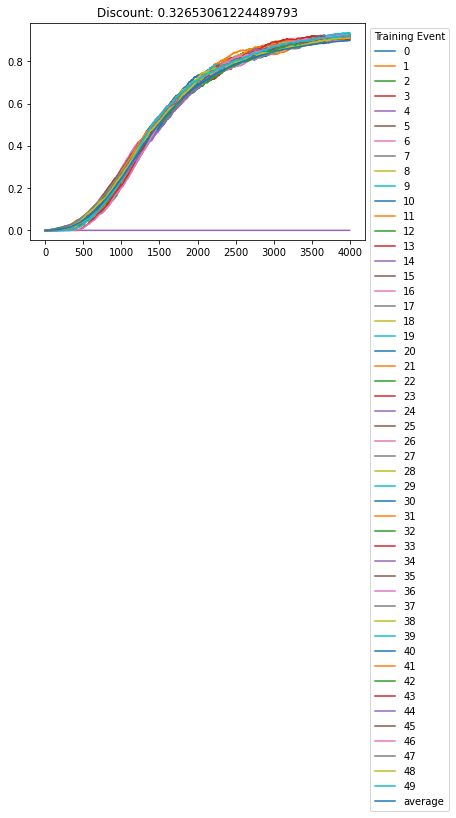

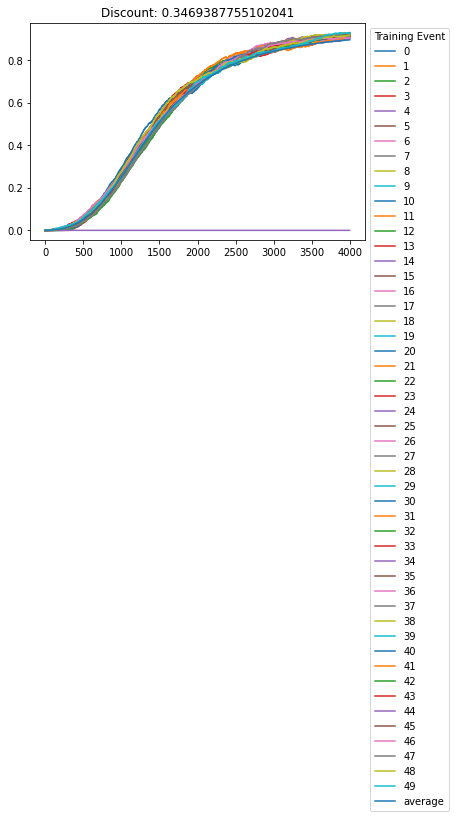

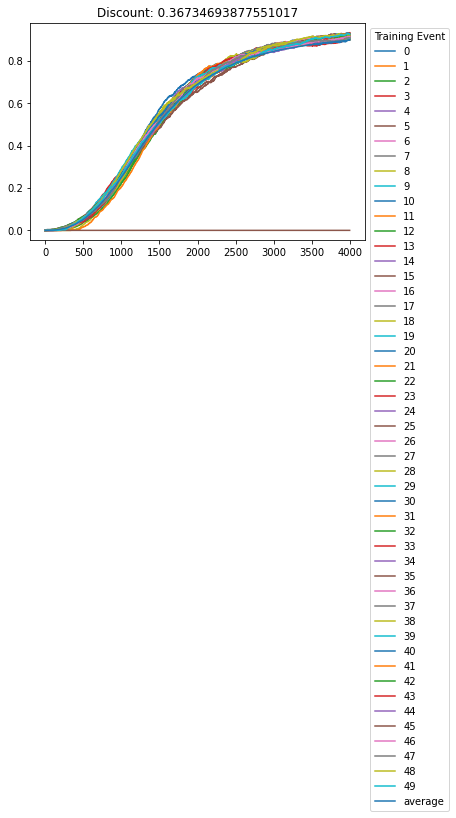

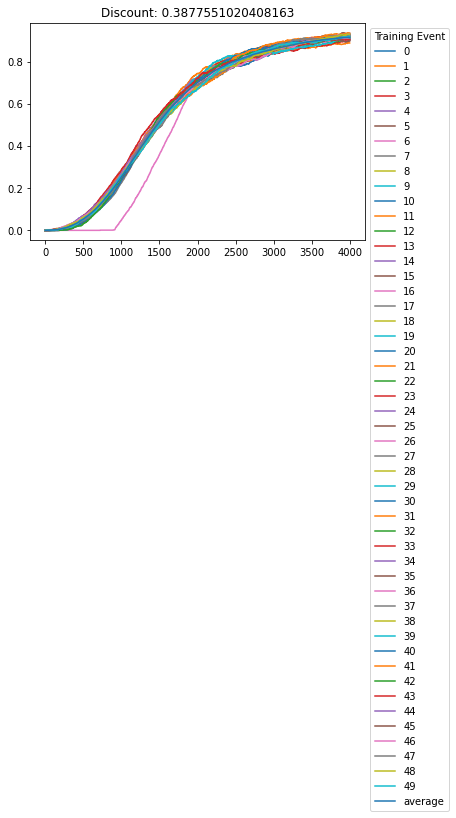

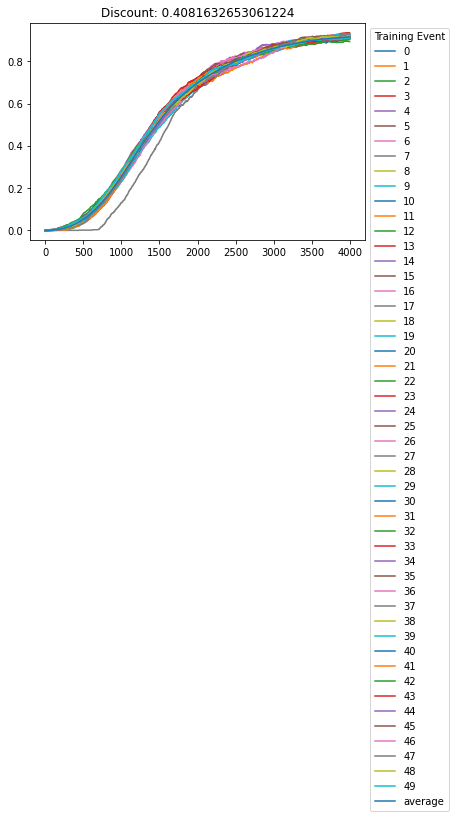

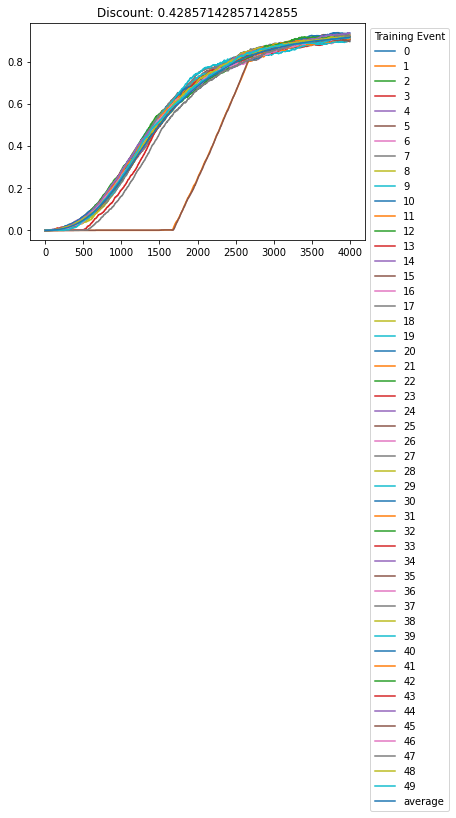

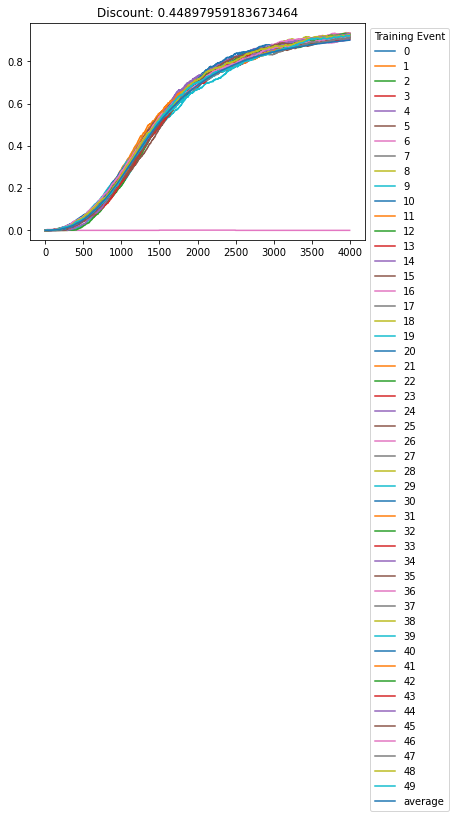

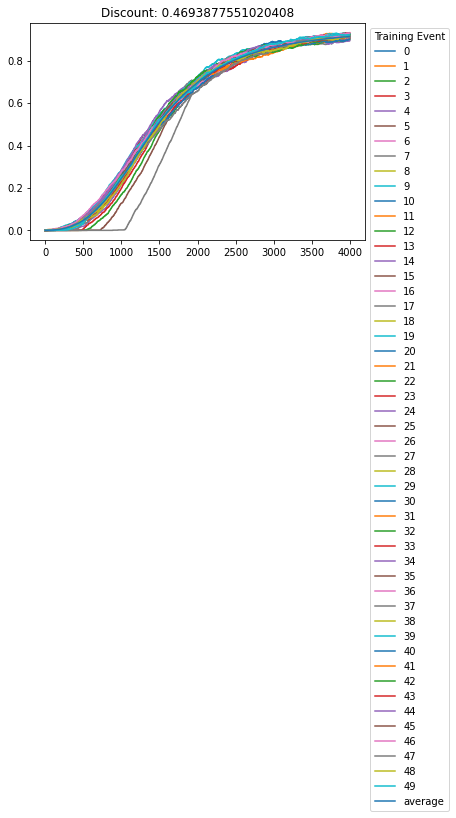

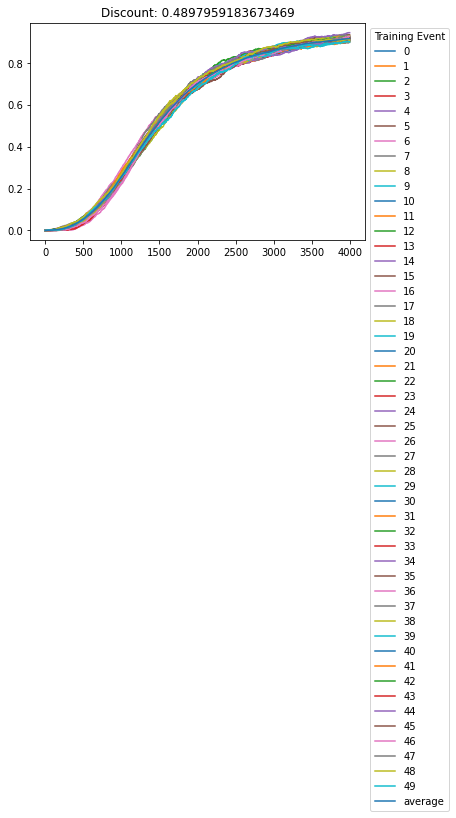

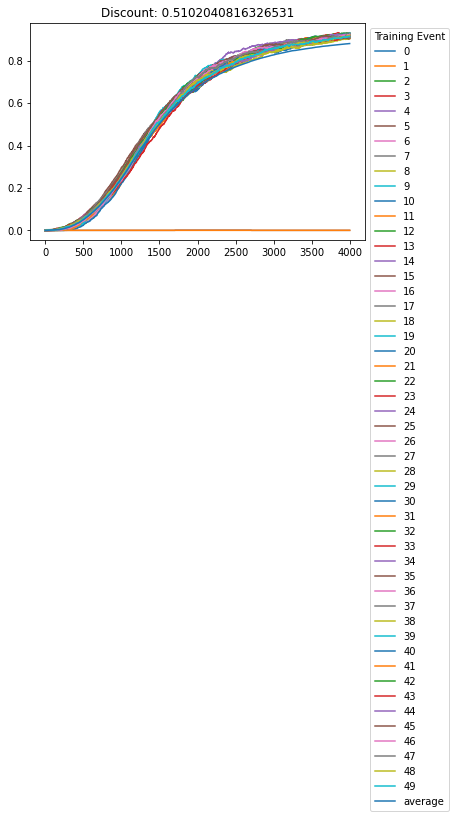

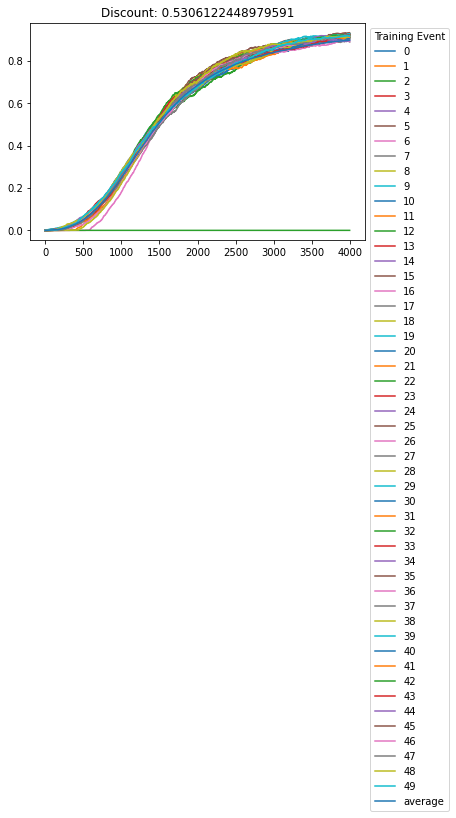

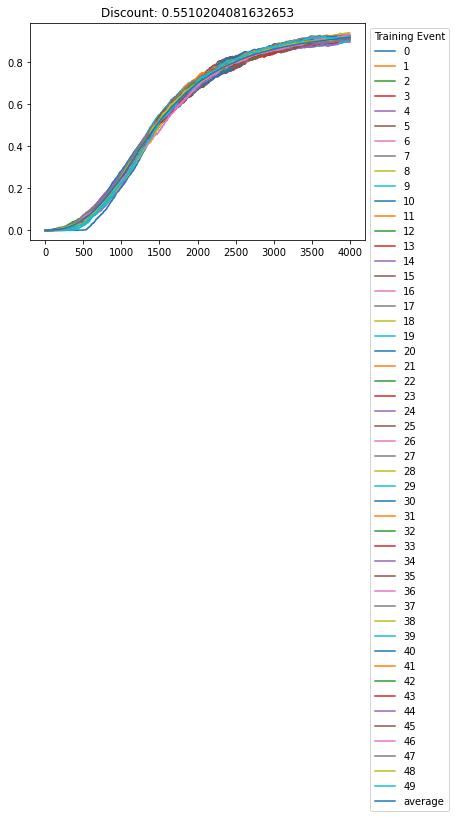

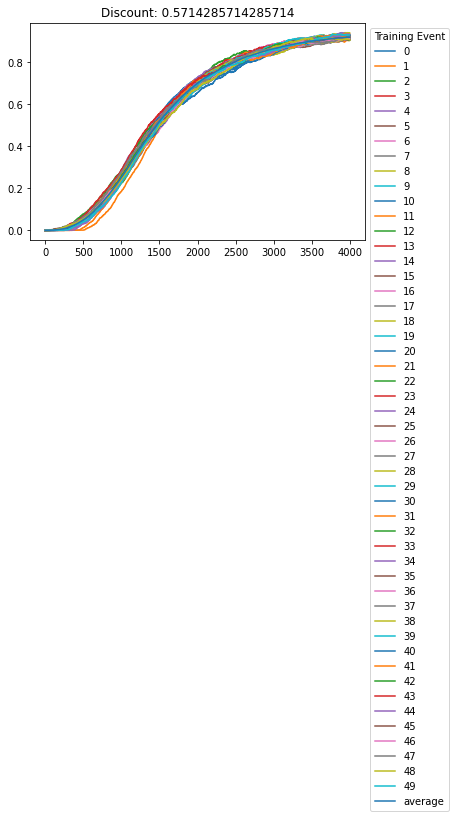

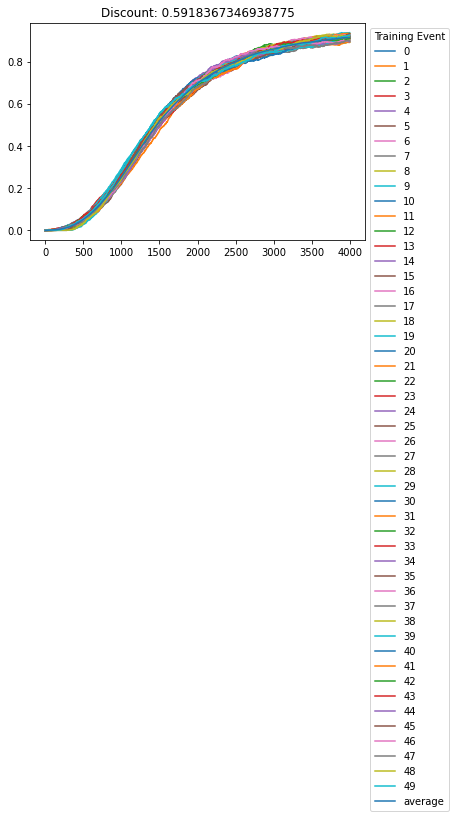

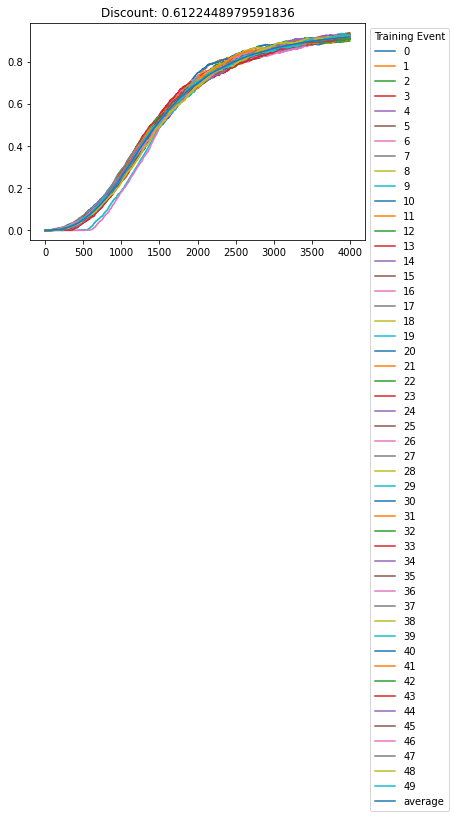

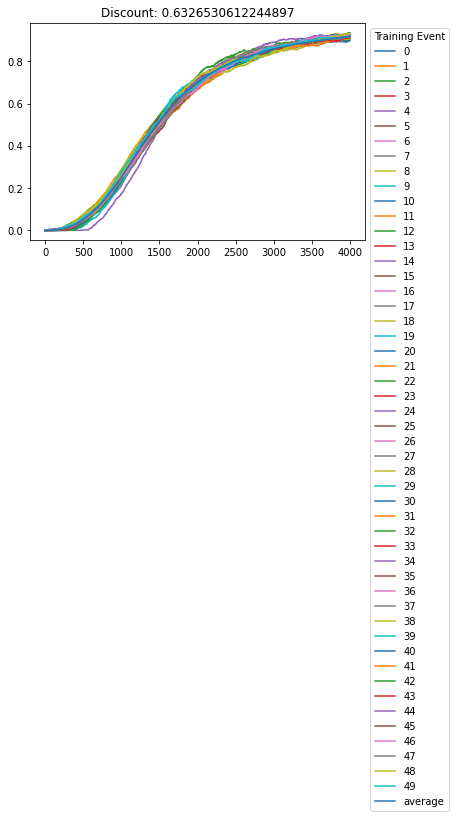

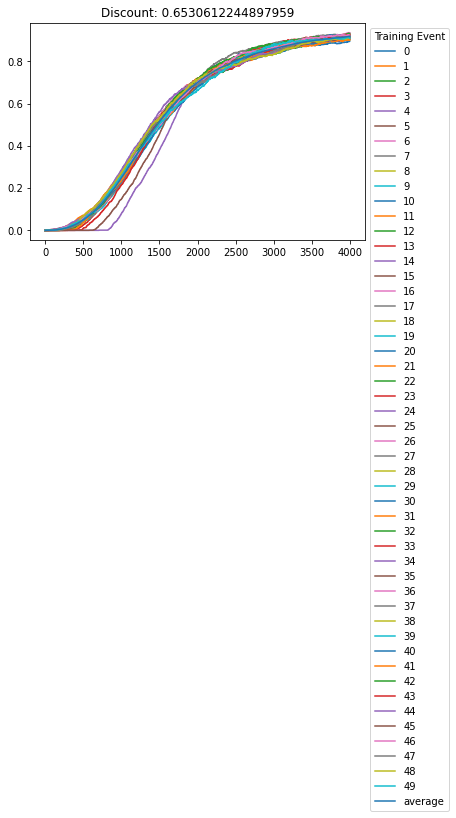

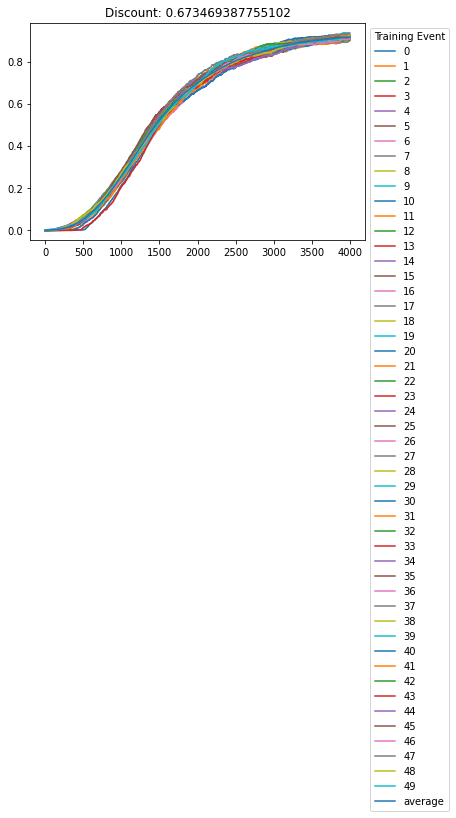

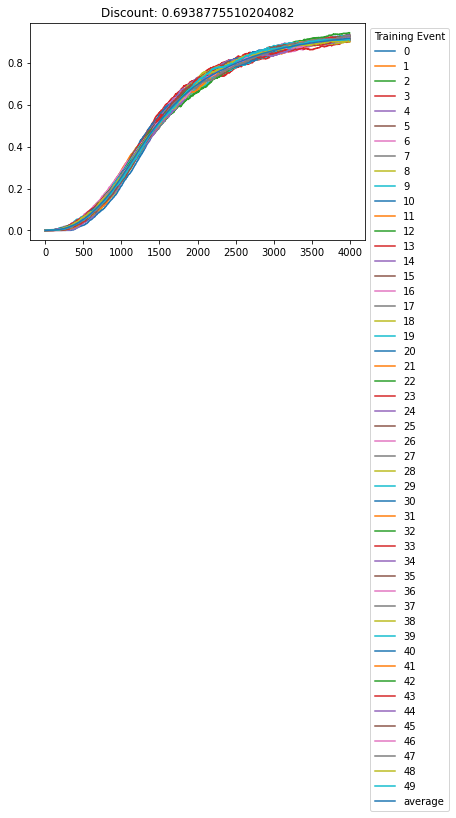

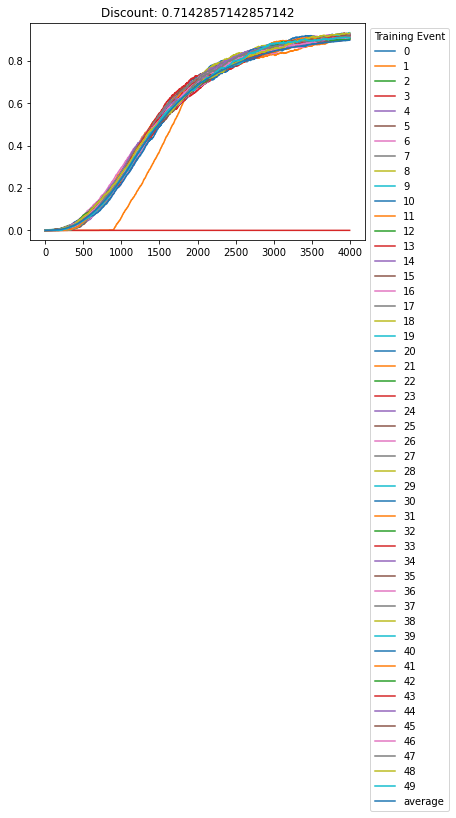

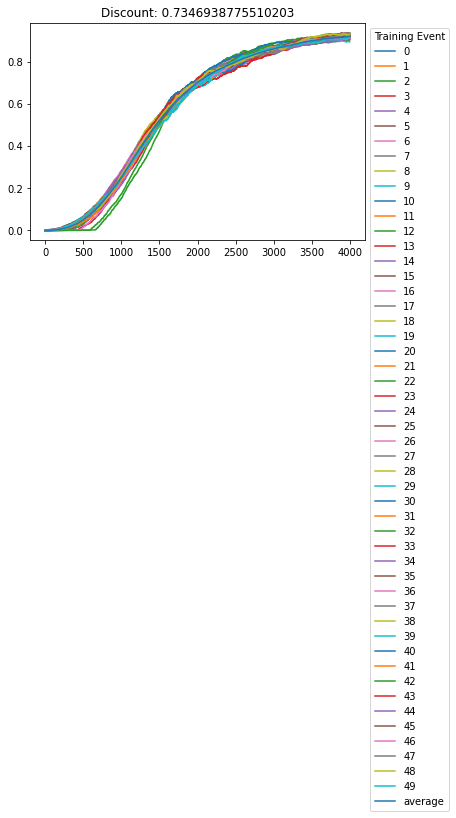

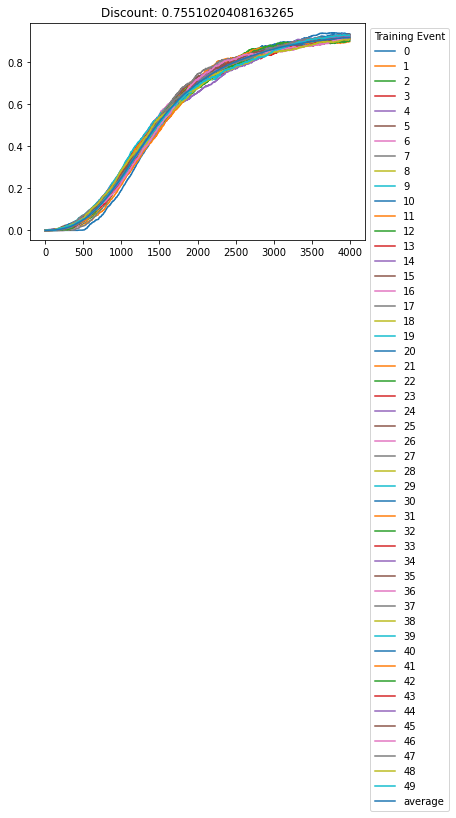

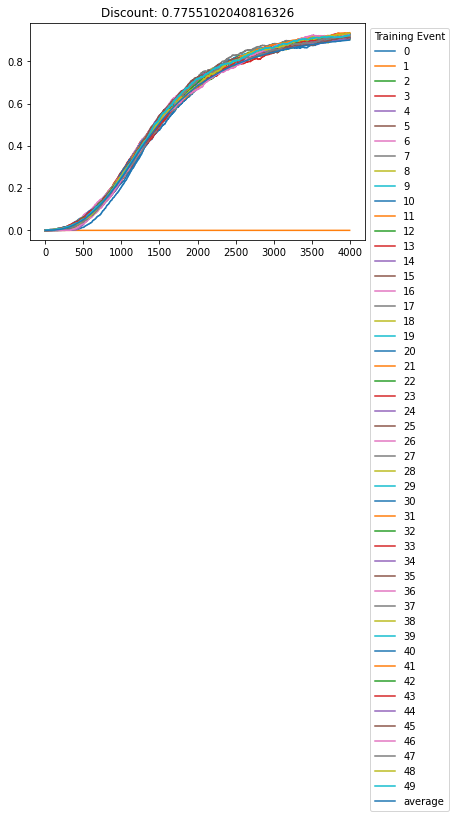

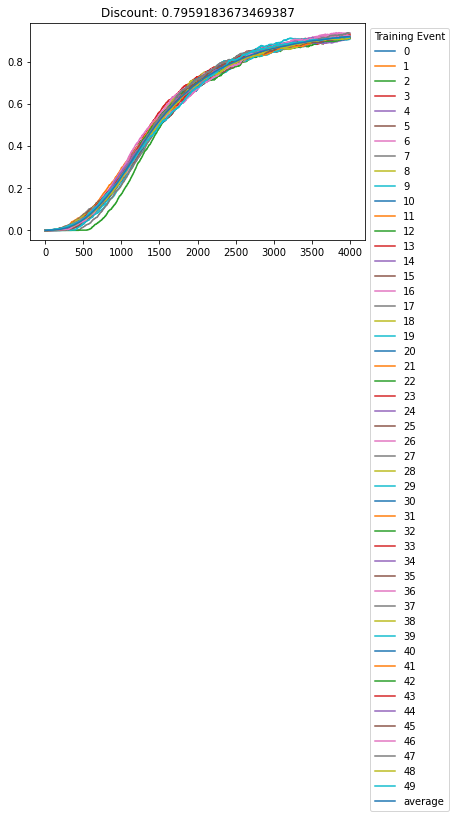

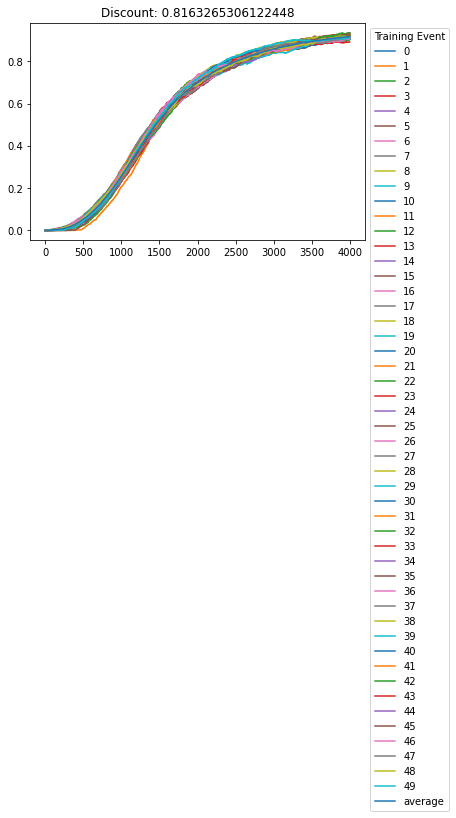

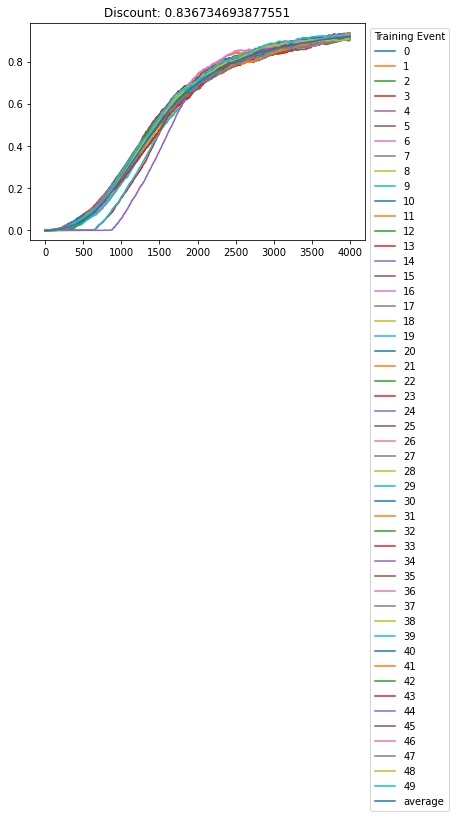

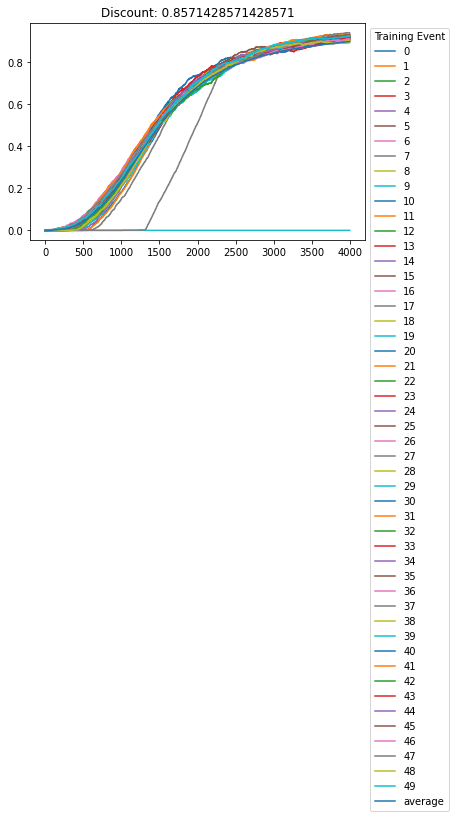

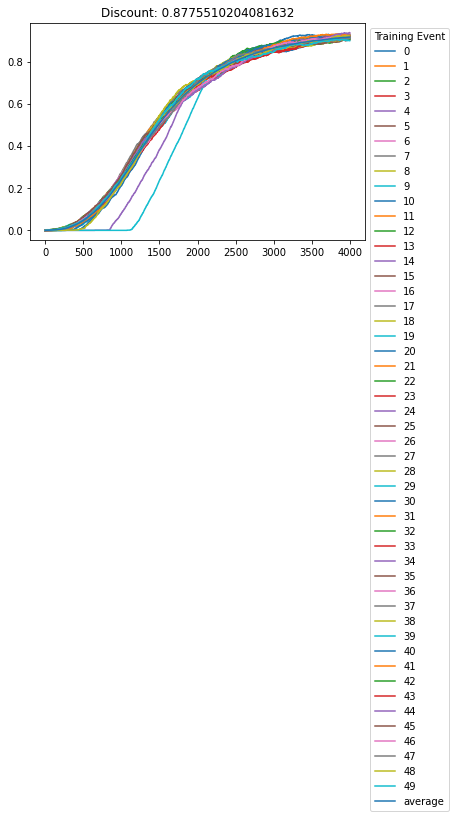

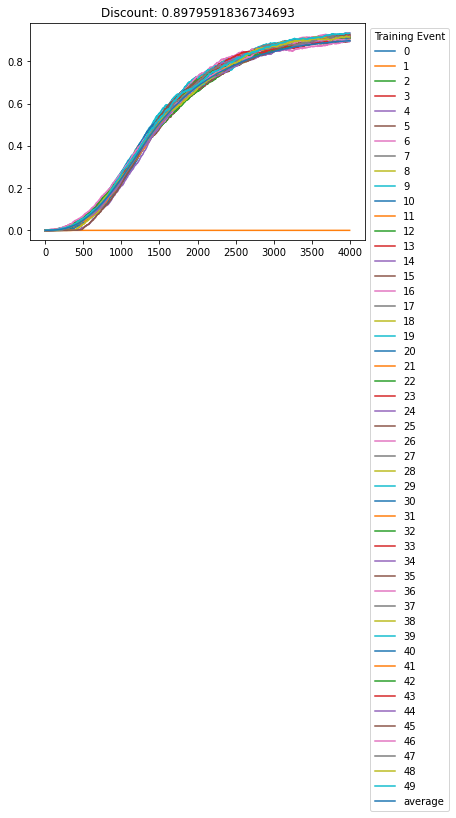

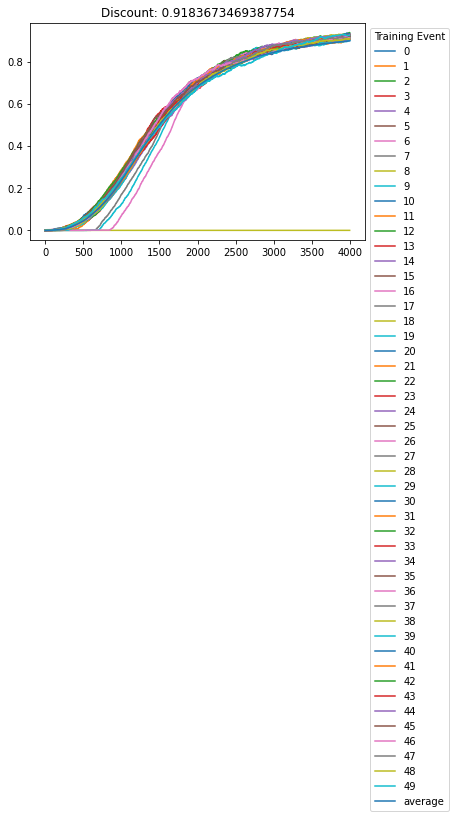

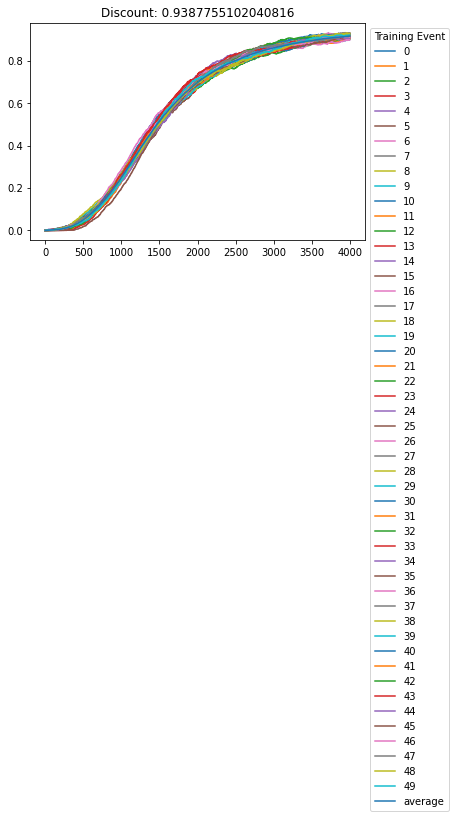

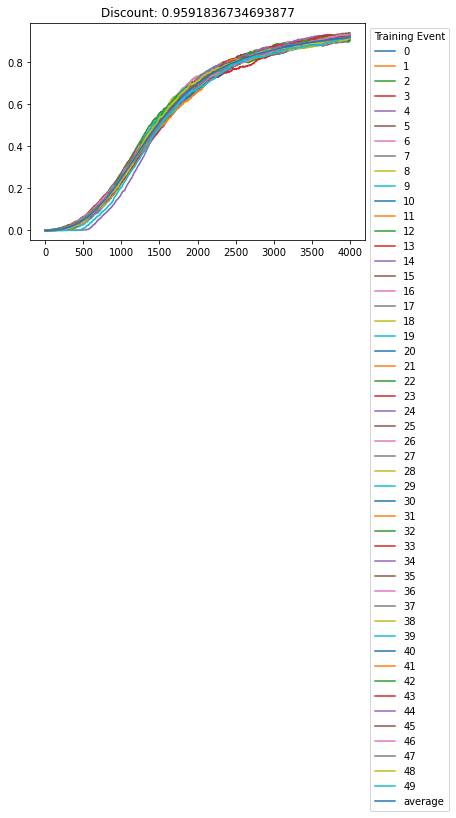

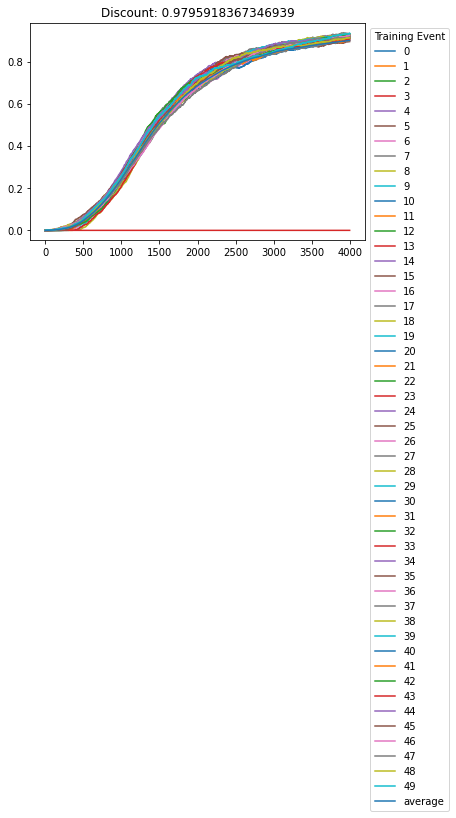

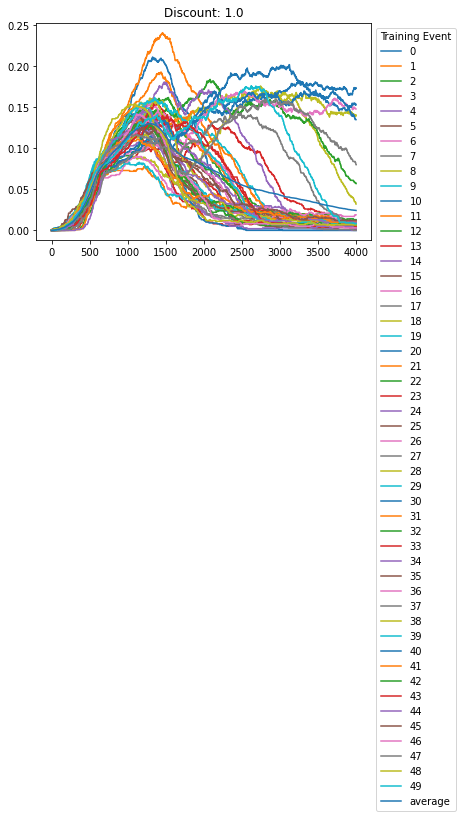

In [256]:
env = gym.make("FrozenLake-v1", map_name="4x4",
               is_slippery=False, new_step_api=True)

number_tests = 50
training_event_per_test = 50
number_episodes = 4000


max_discount = 1
min_discount = 0

max_discount = 1
min_discount = 0


discount_space = np.linspace(
    min_discount, max_discount, number_tests)

discount_average_rewards = []
discount_average_smoothed_rewards = []


test_progress = widgets.FloatProgress(
    value=0,
    min=min_discount,
    max=max_discount,
    description='discount:',
    bar_style='info',
    style={'bar_color': 'red'},
    orientation='horizontal'
)
event_progress = widgets.FloatProgress(
    value=0,
    min=0,
    max=training_event_per_test,
    description='training event:',
    bar_style='info',
    style={'bar_color': 'red'},
    orientation='horizontal'
)
display(test_progress)
display(event_progress)


for discount in discount_space:

    test_rewards = []
    test_smoothed_rewards = []

    for event in range(training_event_per_test):
        _, reward, _ = trainModel(
            env, number_episodes, 0.5, discount, epsilon_decay=0.001)
        smoothed_reward = movingAverage(reward, 1000)

        test_rewards.append(reward)
        test_smoothed_rewards.append(smoothed_reward)

        event_progress.value = event
        plt.plot(smoothed_reward, label=event)

    test_reward_average = np.mean(test_rewards, 0)
    test_reward_smoothed_average = movingAverage(test_reward_average, 1000)

    plt.plot(test_reward_smoothed_average, label="average")
    plt.legend(title="Training Event", bbox_to_anchor=(1, 1))
    plt.title("Discount: {0}".format(discount))

    plt.show()

    discount_average_rewards.append(test_reward_average)
    discount_average_smoothed_rewards.append(test_reward_smoothed_average)

    test_progress.value = discount

plt.show()


In [257]:
range_start_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=number_episodes,
    step=100,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
range_end_slider = widgets.IntSlider(
    value=number_episodes,
    min=0,
    max=number_episodes,
    step=100,
    description='Test:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def figureRange(x,y):
  for test in range(len(discount_space)):
    plt.plot(np.arange(x,y),np.asarray(discount_average_smoothed_rewards)[test][x:y], label=discount_space[test])
  plt.legend(title="Training Event", bbox_to_anchor=(1,1))
  plt.show()
  
  range_end_slider.min = x
  range_start_slider.max = y

widgets.interact(figureRange, x=range_start_slider, y = range_end_slider)

interactive(children=(IntSlider(value=0, description='Test:', max=4000, step=100), IntSlider(value=4000, descr…

<function __main__.figureRange(x, y)>

In [268]:
slice_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=number_episodes,
    step=50,
    description='Episode:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def plotSlice(x):
    plt.plot(learning_rate_space[1:], np.asarray(learning_rate_average_smoothed_rewards)[1:, x])
    plt.xlabel("Discount")
    plt.ylabel("Score at episode")
    plt.show()

widgets.interact(plotSlice, x=slice_slider)

interactive(children=(IntSlider(value=0, description='Episode:', max=4000, step=50), Output()), _dom_classes=(…

<function __main__.plotSlice(x)>

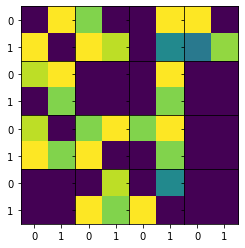

In [259]:


fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0,  # pad between axes in inch.
                 )

for ax, im in zip(grid, q_table.reshape(16,2,2)[:,:,0:]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()